In [1]:
import optuna
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Analysis of the optuna optimization
In this notebook we provide a detailed analysis of the optuna run to find the best hyperparameters for the VAE eployed to preprocess the ToF images from the experiment. Notice that this is only the final run.

In [2]:
face_colors = {
    'orange': [0.8906, 0.4609, 0.4062],
    'gray': [0.6523, 0.6484, 0.6484],
    'blue': [0.5156, 0.5977, 0.8789]
}
edge_colors = {
    'orange': [0.9961, 0, 0],
    'gray': [0.4805, 0.4766, 0.4766],
    'blue': [0, 0, 0.9961]
}

edge_colors_arr = [ec for ec in edge_colors.values()]
face_colors_arr = [fc for fc in face_colors.values()]

cycler = (plt.cycler(mec=edge_colors_arr)+
          plt.cycler(mfc=face_colors_arr)+
          plt.cycler(color=edge_colors_arr))

plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 24,
    'lines.markeredgewidth': 2,
    'lines.markersize': 9,
    'lines.marker': 'o',
    'lines.linestyle': '',
    'lines.linewidth': 3,
    'axes.prop_cycle': cycler
    })

Here we load the trials from the optuna run

In [3]:
with open('networks/micromotion_rephasing/optuna_trials.pkl', 'rb') as input:
    all_trials = pickle.load(input)

In [4]:
study = optuna.study.create_study()

[I 2021-04-19 12:20:50,006] A new study created in memory with name: no-name-1021ef6c-42b8-402a-b6b5-5bcd8a4cb80e


In [5]:
study.add_trials(all_trials)

<ipython-input-5-08d98137b4a8>:1: ExperimentalWarning: add_trials is experimental (supported from v2.5.0). The interface can change in the future.
  study.add_trials(all_trials)
/afs/physnet.uni-hamburg.de/project/las_o/theory_and_ml/environments/physnet/3_9_2/optuna/lib/python3.9/site-packages/optuna/study.py:946: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(trial)


# General evaluation of the study

In [6]:
evaluateable_trials = []
for trial in all_trials:
    if trial.state != optuna.trial.TrialState.RUNNING:
        evaluateable_trials.append(trial)

In [7]:
print("Total number of trials: {}".format(len(evaluateable_trials)))

Total number of trials: 33534


In [8]:
durations = []
states = []
final_loss = []
for trial in evaluateable_trials:
    states.append(trial.state)
    final_loss.append(trial.value)
    if trial.state == optuna.trial.TrialState.COMPLETE:
        durations.append(trial.duration.total_seconds())
    else:
        durations.append(-1)
durations = np.array(durations)
states = np.array(states)
final_loss = np.array(final_loss)

In [9]:
print('Number of stopped trials: {}'.format(np.sum(states == optuna.trial.TrialState.FAIL)))
print('Number of pruned trials: {}'.format(np.sum(states == optuna.trial.TrialState.PRUNED)))
print('Number of completed trials: {}'.format(np.sum(states == optuna.trial.TrialState.COMPLETE)))

Number of stopped trials: 32539
Number of pruned trials: 435
Number of completed trials: 560


In [10]:
best_trial_time = study.best_trial.duration.total_seconds()/60/60
completed_avg_trial_time = np.sum(durations[states == optuna.trial.TrialState.COMPLETE])/60/60
total_time = np.sum(durations)/60/60
print('Time for best trial: {}'.format(best_trial_time))
print('Time average completed trial: {}'.format(completed_avg_trial_time))
print('Total time: {}'.format(total_time))

Time for best trial: 10.813333333333333
Time average completed trial: 6581.334444444444
Total time: 6572.175


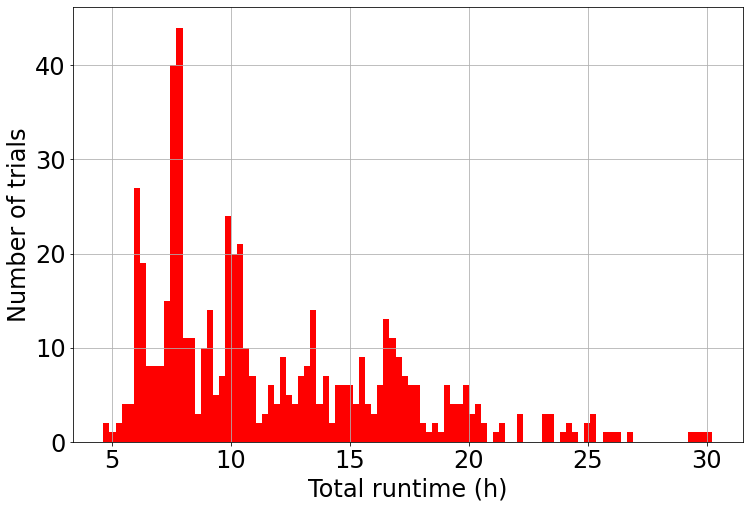

In [11]:
res = plt.hist(durations[states == optuna.trial.TrialState.COMPLETE]/60/60, bins=100)
plt.xlabel('Total runtime (h)')
plt.ylabel('Number of trials')
plt.grid()
plt.savefig('plots/runtime_trial.pdf', bbox_inches='tight')

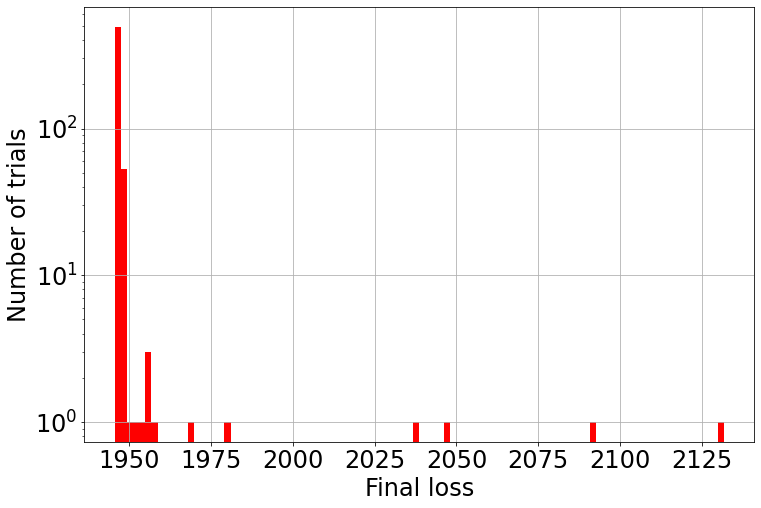

In [12]:
plt.hist(final_loss[states == optuna.trial.TrialState.COMPLETE], bins=100)
plt.xlabel('Final loss')
plt.ylabel('Number of trials')
plt.yscale('log')
plt.grid()
plt.savefig('plots/final_loss_trial.pdf', bbox_inches='tight')

# Hyperparameter Importance for the CVAE

Calculate and plot the parameter importance accoding to Hutter et al.,Proceedings of the 31st International Conference on Machine Learning, PMLR 32(1):754-762, 2014.

The most important Hyperparameter is the number of fully connected layers in the decoder. Hence the number of layers behind the bottleneck.

<ipython-input-13-beae30ec4eb4>:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


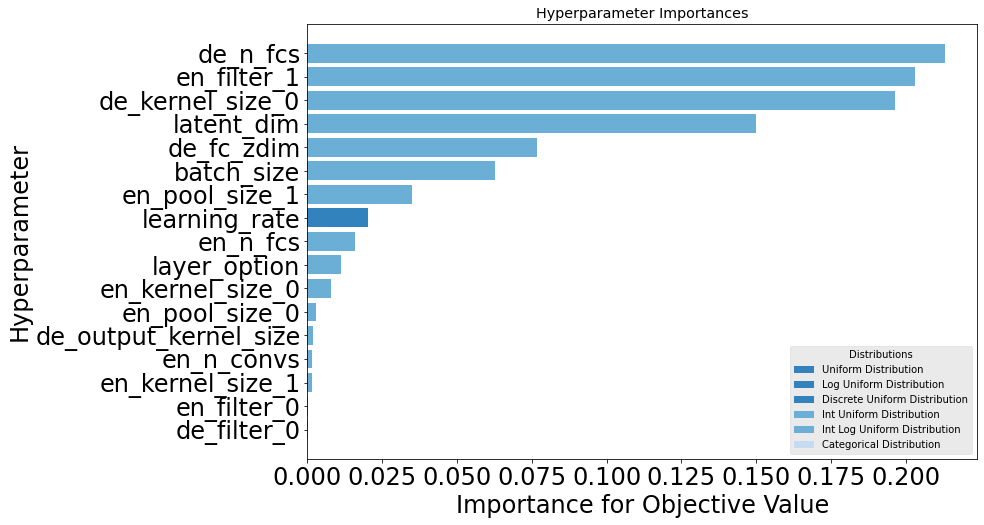

In [13]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.savefig('plots/parameter_importance.pdf', bbox_inches='tight')

In [14]:
importances = optuna.importance.get_param_importances(study)

In [15]:
importances

OrderedDict([('de_n_fcs', 0.28677438311800363),
             ('latent_dim', 0.19548972988911403),
             ('en_filter_1', 0.17320490336017338),
             ('de_fc_zdim', 0.1312025134946161),
             ('de_kernel_size_0', 0.08897556830033106),
             ('en_pool_size_1', 0.026961993310882573),
             ('batch_size', 0.025698787045759917),
             ('layer_option', 0.016444126507168057),
             ('en_filter_0', 0.01413465195161586),
             ('en_kernel_size_1', 0.012053531496989282),
             ('de_filter_0', 0.009134999226426781),
             ('en_kernel_size_0', 0.008428757612547693),
             ('en_n_fcs', 0.005512778855433972),
             ('learning_rate', 0.002731315106725946),
             ('en_pool_size_0', 0.001687597995502599),
             ('de_output_kernel_size', 0.0009241212975589733),
             ('en_n_convs', 0.0006402414311499181)])